# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
np.random.seed(13)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [ ]:
np.random.seed(13)

def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape

    sigma = np.zeros((d, d))
    w = np.zeros(d)

    relevant = alpha < np.inf
    X_relevant = X[:, relevant]
    alpha_relevant = alpha[relevant]

    sigma_relevant = np.linalg.inv(beta * X_relevant.T @ X_relevant + np.diag(alpha_relevant))
    w[relevant] = beta * sigma_relevant @ X_relevant.T @ t

    sigma[np.ix_(relevant, relevant)] = sigma_relevant

    return w, sigma


def update_alpha_beta(X, t, alpha, beta, boundary=1e-8): # пришлось добавить, иначе ворнинги лезут :(
    """Update the hyperperemeters to increase evidence"""

    n, d = X.shape
    w, sigma = get_w_sigma(X, t, alpha, beta)

    relevant = (alpha < np.inf) & (alpha > boundary)
    alpha_new = alpha.copy()
    alpha_new[relevant] = (1 - alpha[relevant] * np.diag(sigma)[relevant]) / (w[relevant] ** 2)
    alpha_new[~relevant] = np.inf

    resid = t - X @ w
    beta_new = (n - (1 - alpha[relevant] * np.diag(sigma)[relevant]).sum()) / np.dot(resid, resid)

    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""

    alpha = np.ones(X.shape[1])
    beta = 1.0

    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta)

    w, sigma = get_w_sigma(X, t, alpha, beta)

    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

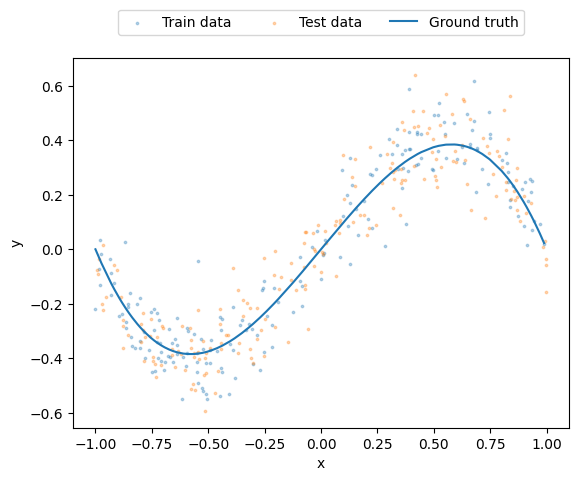

In [ ]:
# Data generation
np.random.seed(13)

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [ ]:
# Relevance Vector Regression
np.random.seed(13)
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [ ]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV

np.random.seed(13)
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [ ]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso

np.random.seed(13)
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

Relevance Vector Regression
Features remaining: 3 / 21
Train error: 0.008836899279253642
Test error:  0.010494546831379039
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.008793484121375685
Test error:  0.010617549091398448
--------------------------------------------------
Lasso Regression
Features remaining: 8 / 21
Train error: 0.008768205116256388
Test error:  0.01055686808791514


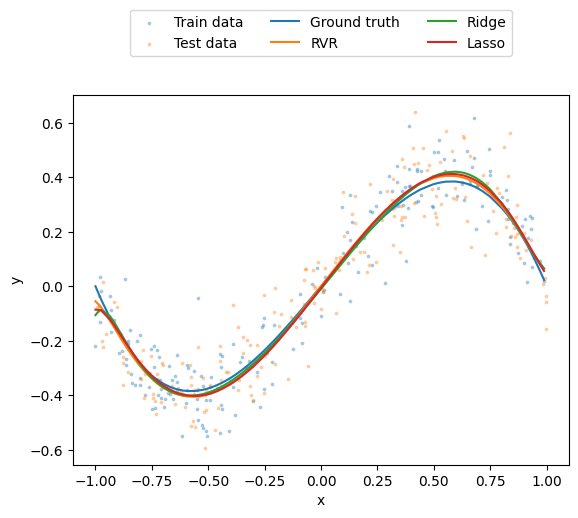

In [ ]:
# Comparison
np.random.seed(13)
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

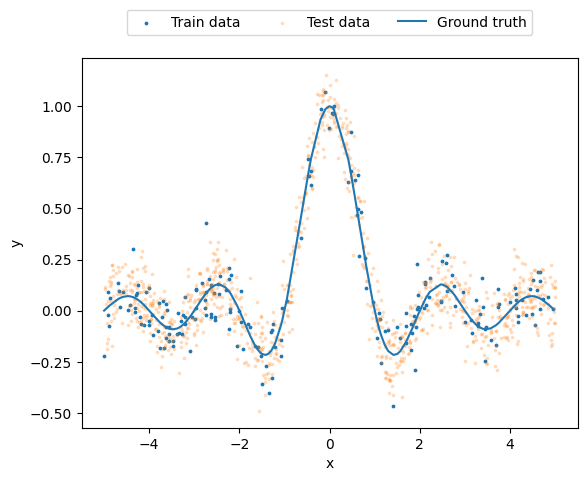

In [ ]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

np.random.seed(13)

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train[:, None])
X_test = rbf_kernel(points_test[:, None], points_train[:, None])

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [ ]:
# Relevance Vector Regression
np.random.seed(13)
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [ ]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV

np.random.seed(13)
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [ ]:
# Support Vector Regression
from sklearn.svm import SVR

np.random.seed(13)
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 11 / 200
Train error: 0.009033664220697226
Test error:  0.05350254537458996
--------------------------------------------------
Lasso Regression
Objects remaining: 104 / 200
Train error: 0.008709437913834363
Test error:  0.05169356791838227
--------------------------------------------------
Support Vector Regression
Objects remaining: 59 / 200
Train error: 0.008912571715252896
Test error:  0.053279815459424326


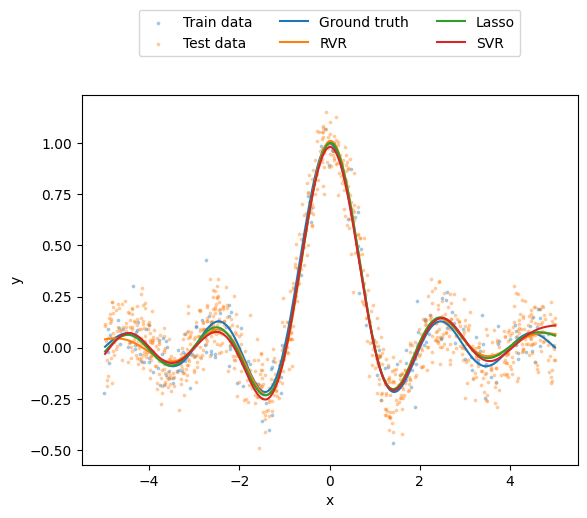

In [ ]:
# Comparison
np.random.seed(13)

print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

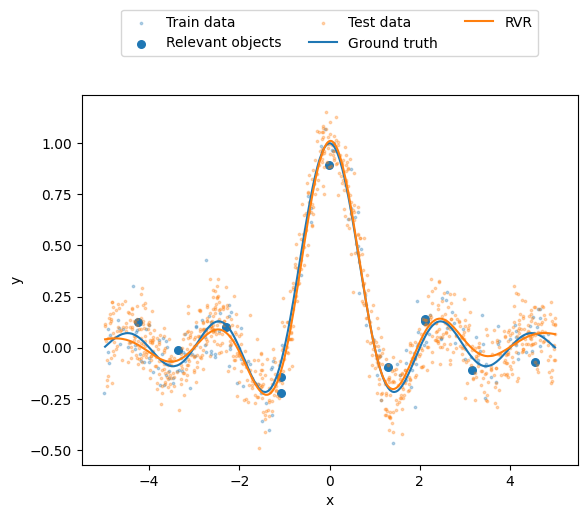

In [ ]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы

Окей, сначала наблюдения по пунктам заданий, а потом общие.

+ "Восстановление полинома" - тут вышло, что RVR оставляет меньше признаков в сравнении с другими моделями, то есть жестче и лучше их отбирает. Ошибка на тестовой выборке у RVR немного ниже (совсем чуть-чуть, но все-таки ниже, хех), чем у Lasso и Ridge, так что выходит, что RVR хорошо справляется с задачей на небольшом количестве отобранных признаков, а это круто. К слову, Ridge признаки вообще не отбирала, так как не поддерживает sparsity.

+ "Регрессия с RBF-признаками" - тут RVR тоже отобрал сильно меньше объектов (опрных/релевантных в смысле), у него 11, а дальше у SVR - 59 и у Lasso - 104. Качество на тесте тут у RVR немного пониже, чем у обоих методов, но с учетом того, что объектов сильно меньше, то это довольно крутой результат, на мой взгляд. Lasso тут показал лучший результат как будто как раз за счет того, что больше объектов как релефантные/опорные использовал. SVR оказался золотой серединой во всех отношениях, я бы сказала, плюс он же именно опорные объекты ищет, они довольно сложные обычно.

+ И вот важное отдельным пунктом. По визуализации релевантных объектов для RVR видно, что он (маленькие будни лингвиста, у меня в голове RVR мужского рода, хотя так-то не аббревиатура - женского... на это когда-то даже интересные олимпиадные задачки были...) выбрал исключительно объекты, соответсвтующие примерно экстремумам (и одну около) функции sinc(x). То есть он может выделять ключевые данные, которые позволяют восстановить структуру функции. Вот так.

В остальном, RVR хорош для шумных данных, как мы увидели. Еще он, по сути, выдает разреженный результат и некую дисперсию прогноза.

И еще почему-то в ноутбуке сид был фиксирован не в каждой ячейке (а только в верхней его фиксировать бессмысленно, так что я его везде проставила). И понятно, что сид влияет на удачность результатов, а значения ошибок на тестовых выборках между моделями у нас очень близкие, так что иногда RVR будет получше, иногда чуть-чуть нет, но я потыкала сиды и поняла, что главное, что значения ошибки на тестовой выборке у RVR никогда не отклоняются слишком сильно от того, с чем мы его сравниваем, то есть стабильным остается вывод, что эта регрессия дает нам возможность работать с меньшим количеством признаков/объектов, не теряя сильно качество. И так и должно быть, собственно, если опираться на лекцию.